In [ ]:
WS_DIR = "/content/"
%cd $WS_DIR

# Clone the repo and install the basic requirements
!git clone --branch v0.4 https://github.com/ARISE-Initiative/robomimic
!pip install -e robomimic/ > /dev/null

import sys
import os
sys.path.append('./robomimic/')

/content
Cloning into 'robomimic'...
remote: Enumerating objects: 3546, done.
remote: Counting objects: 100% (1647/1647), done.
remote: Compressing objects: 100% (381/381), done.
remote: Total 3546 (delta 1436), reused 1266 (delta 1266), pack-reused 1899 (from 2)
Receiving objects: 100% (3546/3546), 62.07 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (2468/2468), done.
Updating files: 100% (185/185), done.


In [ ]:
# install all system dependencies for mujoco-py
!sudo DEBIAN_FRONTEND=noninteractive apt install curl git libgl1-mesa-dev libgl1-mesa-glx libglew-dev \
         libosmesa6-dev software-properties-common net-tools unzip vim \
         virtualenv wget xpra xserver-xorg-dev libglfw3-dev patchelf > /dev/null

#install mujoco-py
!pip install mujoco==3.3.0 > /dev/null

#install robosuite
!pip install robosuite > /dev/null



Extracting templates from packages: 100%


In [ ]:
import mujoco

mujoco.__version__

'3.3.0'

In [ ]:
# import all utility functions

import os
import json
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import robomimic
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.test_utils as TestUtils
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.train_utils as TrainUtils
from robomimic.utils.dataset import SequenceDataset

from robomimic.config import config_factory
from robomimic.algo import algo_factory

# for rendering mujoco in colab, you need turn on egl
os.environ['MUJOCO_GL'] = 'osmesa' # if gpu possible, use 'egl', if not, use 'osmesa'

# the dataset registry can be found at robomimic/__init__.py
from robomimic import DATASET_REGISTRY, HF_REPO_ID

# set download folder and make it
download_folder = WS_DIR + "robomimic_data/"
os.makedirs(download_folder, exist_ok=True)

# download the dataset
task = "lift"
dataset_type = "ph"
hdf5_type = "low_dim"
FileUtils.download_file_from_hf(
    repo_id=HF_REPO_ID,
    filename=DATASET_REGISTRY[task][dataset_type][hdf5_type]["url"],
    download_dir=download_folder,
)

# enforce that the dataset exists
dataset_path = os.path.join(download_folder, "low_dim_v15.hdf5")
assert os.path.exists(dataset_path)

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /content/robomimic/robomimic/scripts/setup_macros.py
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


low_dim_v15.hdf5:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
!pip install pydmps > /dev/null

In [ ]:
f = h5py.File(dataset_path, "r")
dataset = np.array(f["data/demo_10/obs/robot0_joint_pos"])

from pydmps import dmp_discrete

dmp = dmp_discrete.DMPs_discrete(n_dmps=7, n_bfs=100, dt=1/dataset.shape[0])

dmp.imitate_path(y_des=dataset.T)
ac, _, _ = dmp.rollout()

<KeysViewHDF5 ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_quat_site', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel']>


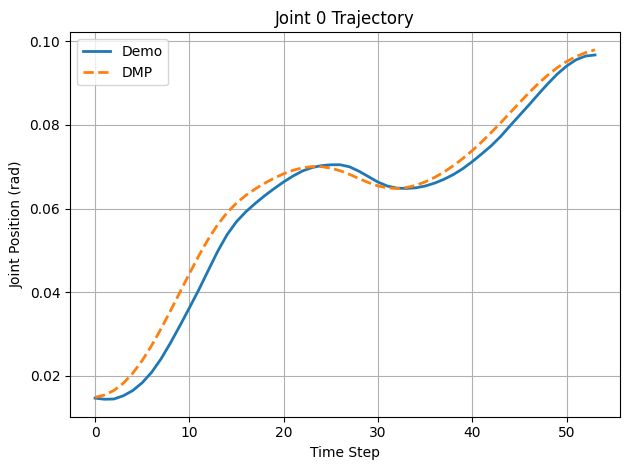

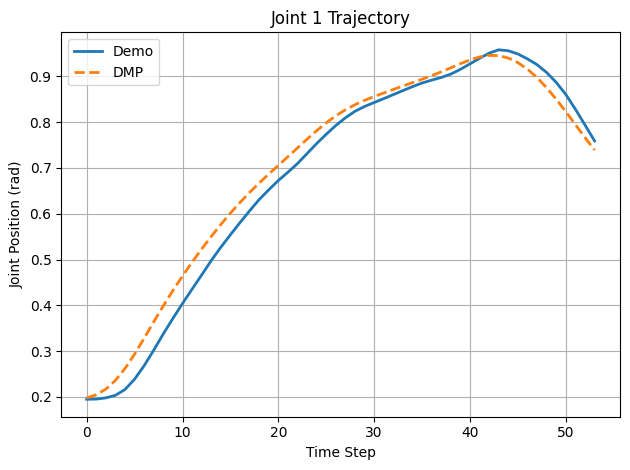

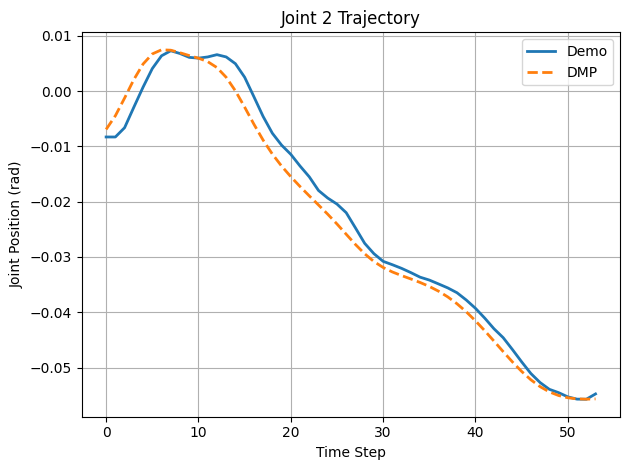

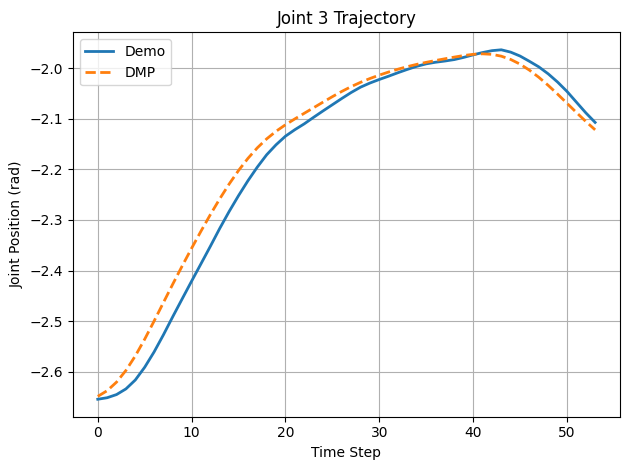

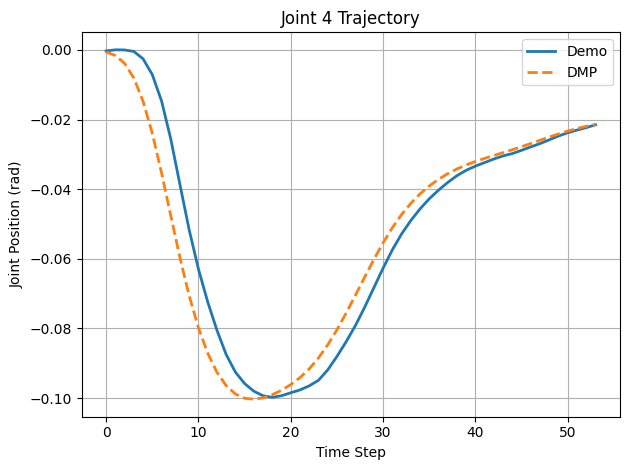

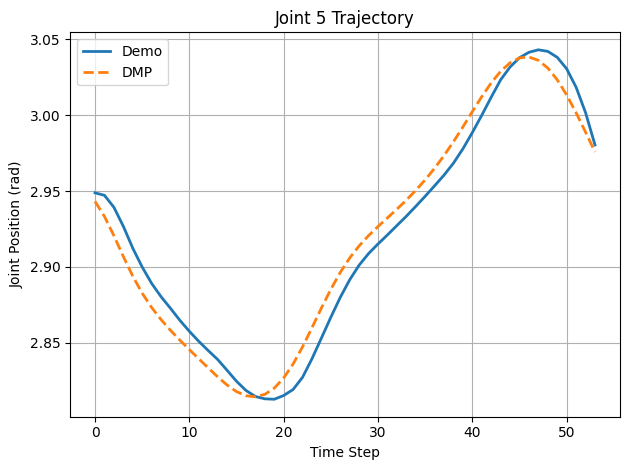

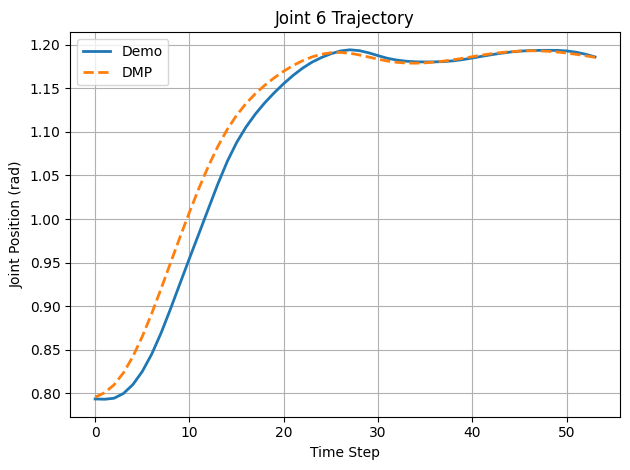

In [ ]:
import matplotlib.pyplot as plt
# Plot
num_joints = dataset.shape[1]
time = np.arange(dataset.shape[0])

for j in range(num_joints):
    plt.figure()
    plt.plot(time, dataset[:, j], label='Demo', linewidth=2)
    plt.plot(time, ac[:, j], '--', label='DMP', linewidth=2)
    plt.title(f'Joint {j} Trajectory')
    plt.xlabel('Time Step')
    plt.ylabel('Joint Position (rad)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import robomimic.utils.env_utils as EnvUtils
from robosuite import load_composite_controller_config
from robosuite.environments.robot_env import RobotEnv
from robosuite.models.tasks import Task
from robosuite.models.arenas.empty_arena import EmptyArena

class Free(RobotEnv):
    def __init__(self, robots, controller_configs):
        super().__init__(robots=robots, controller_configs=controller_configs)

    @property
    def _visualizations(self):
        """
        Visualization keywords for this environment

        Returns:
            set: All components that can be individually visualized for this environment
        """
        vis_set = super()._visualizations
        vis_set.add("grippers")
        return vis_set

    def reward(self, action):
        return 0

    def _load_model(self):
        super()._load_model()

        self.robots[0].robot_model.set_base_xpos([-1, 0, 0])

        mujoco_arena = EmptyArena()
        mujoco_arena.set_origin([0, 0, 0])

        self.model = Task(
            mujoco_arena = mujoco_arena,
            mujoco_robots = [robot.robot_model for robot in self.robots],
        )

    def _check_robot_configuration(self, robots):
        pass

config = load_composite_controller_config(controller="WHOLE_BODY_IK")

env = Free(robots=["Baxter"], controller_configs=config)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /usr/local/lib/python3.12/dist-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)
[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.12/dist-packages/robosuite/controllers/config/default/composite/whole_body_ik.json (composite_controller_factory.py:121)
INFO:robosuite_logs:Loading controller configu

In [ ]:
import imageio
from copy import deepcopy
import numpy as np
import os

os.environ["MUJOCO_GL"] = 'osmesa'

# create a video writer
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

ob_dict = env.reset()
cur_joint_pos = ob_dict["robot0_joint_pos"]
for i in range(50):
    env.step(np.zeros(14))

    frame = env.sim.render(height=512, width=512, camera_name="frontview")[::-1]
    video_writer.append_data(frame)

video_writer.close()

[robosuite WARNING] The config has defined for the controller "torso", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for torso from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "head", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for head from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "base", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for base from self.part_controller_config. (robot.py:151)
[robosuite WARNING] The config has defined for the controller "legs", but the robot does not have this component. Skipping, but make sure this is intended.Removing the controller config for legs from self.part_controller_config. (robot.py:151)


In [ ]:
# visualize rollout video

from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")